# Отток клиентов в телеком

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

**Входные данные:**

- Персональные данные о некоторых клиентах, информация об их тарифах и договорах: [final_provider.zip](https://s3-us-west-2.amazonaws.com/secure.notion-static.com/ac39c23b-718e-4cd6-bdaa-85b3a127a457/final_provider.zip)

Данные также находятся в папке `/datasets/final_provider/`

**Цель**

- Разработать модель прогнозирования оттока клиентов с метрикой roc_auc не менее 0.85.

**Условия задачи**
- Срок выполнения проекта - 7 дней.
- Подготовить не менее 3х моделей и выбрать лучшую по метрике roc_auc.
- RANDOM_STATE фиксируем = 270123

**Описание услуг**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## План

1. Предварительный анализ
    - Выгрузка, чтение, получение общей информации.
    - Проверка валидности данных. Обработка пропусков и дубдикатов.
    - Объединение таблиц.


2. Исследовательский анализ
    - Определить целевой признак.
    - Изучение корреляции признаков.
    - Анализ категориальных и количественных признаков.
    - Составить портрет клиента.


3. Обучение модели
    - Предобработка данных для обучения. Масштабирование и кодирование признаков.
    - Выбор ключевой метрики.
    - Отбор необходимых признаков.
    - Подбор гиперпараметров и построение моделей.
    - Выбор лучшей модели.


4. Тестирование лучшей модели

5. Вывод

## Предварительный анализ
### Выгрузка, чтение, получение общей информации.

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import phik
import seaborn as sns
import warnings

from catboost import CatBoostClassifier
from phik.report import plot_correlation_matrix
from phik import report
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, recall_score, precision_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

RANDOM_STATE = 270123

In [3]:
try:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
except:
    contract = pd.read_csv(r'C:\Users\trifo\contract.csv')

In [4]:
try:
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
except:
    internet = pd.read_csv(r'C:\Users\trifo\internet.csv')

In [5]:
try:
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
except:
    personal = pd.read_csv(r'C:\Users\trifo\personal.csv')

In [6]:
try:
    phone = pd.read_csv('/datasets/final_provider/phone.csv')
except:
    phone = pd.read_csv(r'C:\Users\trifo\phone.csv')

In [7]:
def preproc(df):
    print(df.shape)
    print(df.info())
    print("Количество дубликатов:", df.duplicated().sum())
    print("Количество пропусков:", df.isnull().sum().values.sum())
    
    return df.head(10)

In [8]:
preproc(contract)

(7043, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
Количество дубликатов: 0
Количество пропусков: 0


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


In [9]:
preproc(internet)

(5517, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None
Количество дубликатов: 0
Количество пропусков: 0


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


In [10]:
preproc(personal)

(7043, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
Количество дубликатов: 0
Количество пропусков: 0


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


In [11]:
preproc(phone)

(6361, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
Количество дубликатов: 0
Количество пропусков: 0


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


## Вывод

- Данные похожи на реляционную базу данных. 4 датафрейма с общим ключом `customerID`
- Количество наблюдений в `contract` и `personal` одинаковое (7043). В `internet` - 5517, в `phone` - 6361
- После объединениея, нужно будет обработать пропуски в данных.
- Далее:
    - Объединим датафреймы.
    - Нужно будет создать столбец с целевым признаком (ушел клиент или нет), с булевым значением.
    - Определимся какие признаки нам понадобятся для обучения.
    - Нужно будет применить кодирование признаков.

# Вопросы

1. Как лучше объединять датафреймы? Через merge() или sql().
2. Какую метрику выбрать для обучения? (roc_auc, f-1, accuracy)
3. Важна ли для проекта скорость обучения модели? Какой ключевой параметр оценки модели?
4. Какой метод кодирование лучше использовать? LabelEncoder, OrdinalEncoder?
5. Рекомендации по визуализации

## Исследовательский анализ

Добавим целевой признак (ушел клиент  или нет). Создадим его спомощью столбца `EndDate` таблицы `contract`

In [12]:
contract['Exited'] = contract['EndDate'].apply(lambda x: 1 if x != 'No' else 0)

Заменим типы данных, где это необходимо.\
Чтобы заменить тип данных в столбце `EndDate` таблицы `contract`, нужно сначала заменить значение 'No' на дату. Т.к. "Информация о договорах актуальна на 1 февраля 2020", заменим на эту дату

In [13]:
contract['EndDate'] = contract['EndDate'].apply(lambda x: '2020-02-01' if x == 'No' else x)

Теперь приведем признаки `BeginDate` и `EndDate` к единому типу

In [14]:
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d')
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')

Заменим тип данных признака `TotalCharges` на числовой

In [15]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

Теперь добавим новыq признак:
Срок обслуживания клиентов (в днях), т.к. даты использовать в данном исследовании не стоит, чтобы избежать подглядывания. Сразу переведем данные в формат float.

In [16]:
contract['Period'] = (contract['EndDate'] - contract['BeginDate']) / pd.to_timedelta(1, unit='D')

Проверим

In [17]:
preproc(contract)

(7043, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Exited            7043 non-null   int64         
 9   Period            7043 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(4)
memory usage: 550.4+ KB
None
Количество дубликатов: 0
Количество пропусков: 11


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,Period
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31.0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036.0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61.0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371.0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61.0
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,1,245.0
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,0,671.0
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,301.90,0,306.0
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,1,853.0
9,6388-TABGU,2014-12-01,2020-02-01,One year,No,Bank transfer (automatic),56.15,3487.95,0,1888.0


Посмотрим на пропуски в столбце `TotalCharges`

In [18]:
contract.query('TotalCharges.isna()')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,Period
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0.0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0.0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0.0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0.0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0.0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0.0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0.0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0.0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0.0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,0.0


Данные `BeginDate` и `EndDate` совпадают. Вывод: пользователи только зарегестировались и их траты еще не попали в `TotalCharges`. Заменим данные пропуски на значения столбца `MonthlyCharges`, т.к. на нашу дату они совпадают.

In [19]:
contract['TotalCharges'] = np.where(contract['TotalCharges'].isna() , contract['MonthlyCharges'], contract['TotalCharges'])

Пришло время объединить таблицы в общий датафрейм. Воспользуемся join

In [20]:
df_telecom = contract.merge(internet, on='customerID', how='left')
df_telecom = df_telecom.merge(personal, on='customerID', how='left')
df_telecom = df_telecom.merge(phone, on='customerID', how='left')
df_telecom

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,Period,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31.0,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036.0,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61.0,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371.0,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61.0,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,0,730.0,DSL,Yes,No,Yes,Yes,Yes,Yes,Male,0,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,0,2191.0,Fiber optic,No,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,0,337.0,DSL,Yes,No,No,No,No,No,Female,0,Yes,Yes,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,1,123.0,Fiber optic,No,No,No,No,No,No,Male,1,Yes,No,Yes


In [21]:
df_telecom['SeniorCitizen'] = df_telecom['SeniorCitizen'].apply(lambda x: 'No' if x == 0 else 'Yes')

Проверим пропуски в новом датафрейме

In [22]:
df_telecom.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Exited                 0
Period                 0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
dtype: int64

Допустим, что все клиенты с пропущенными значениями столбца `MultipleLines` не имеют возможности ведения параллельных линий во время звонка, и заменим пропуски на 'No'

Что касается данных об интернет-услугах (`InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV` и `StreamingMovies`), то эти пропуски заменим на 'No', т.к. если бы данные клиенты ими пользовались, данные попали бы в отчет.

In [23]:
df_telecom = df_telecom.fillna('No')

In [24]:
df_telecom.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Exited              0
Period              0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
dtype: int64

Избавимся от признаков, которые очевидно грозят утечкой данных

In [25]:
df_telecom = df_telecom.drop(['customerID', 'BeginDate', 'EndDate'],axis=1)

Посмотрим на распределение значений целевого признака

In [26]:
df_telecom.Exited.value_counts(normalize=True) * 100

0    73.463013
1    26.536987
Name: Exited, dtype: float64

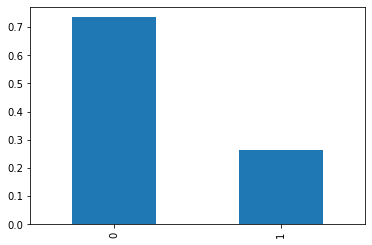

In [27]:
df_telecom.Exited.value_counts(normalize=True).plot(kind='bar');

Отток клиентов за исследуемый период - 26,5% 

Исследуем мультикорреляционность признаков. Воспользуемся библиотекой phik

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'Exited', 'Period']
interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'Exited', 'Period']
interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'Exited', 'Period']


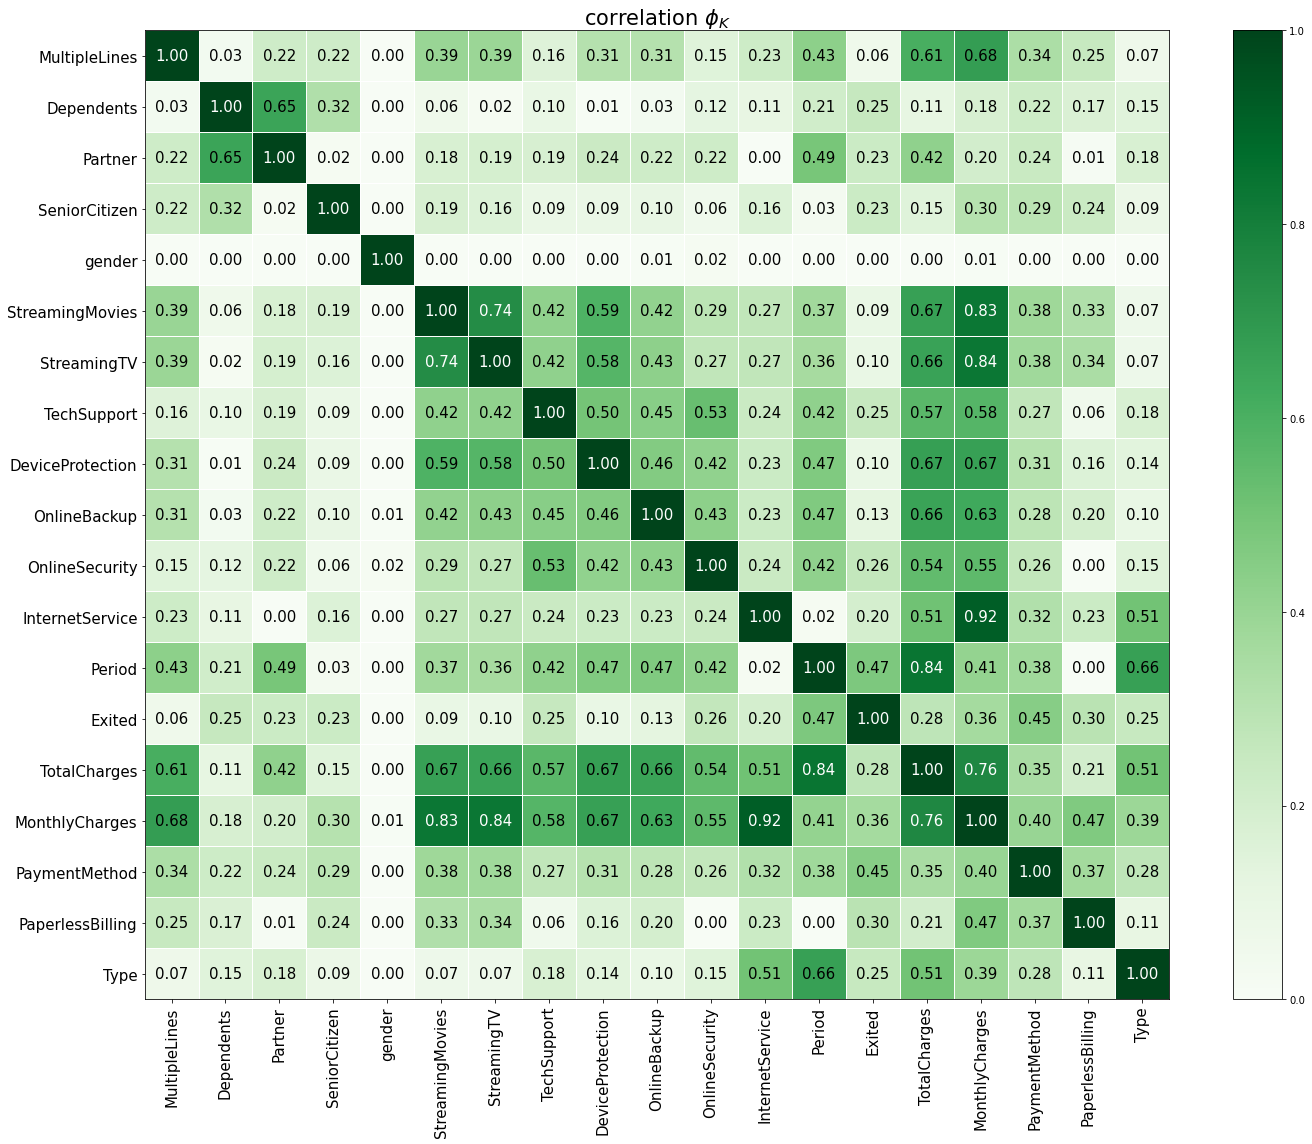

In [28]:
plot_correlation_matrix(df_telecom.phik_matrix().values, 
                        x_labels=df_telecom.phik_matrix().columns, 
                        y_labels=df_telecom.phik_matrix().index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 16))
plt.tight_layout()

- Самая слабая корреляция с другими признаками у пола ('gender'). Можно исключить этот признак.
- MonthlyCharges сильно коррелирует с услугами (InternetService, StreamingMovies и StreamingTV) и TotalCharges.
- TotalCharges сильно коррелирует с продолжительностью действия договоров.
- Сильной мультикоррелиальности с целевым признаком не выявленно.

### Анализ количественных признаков

In [29]:
col_num =  ['MonthlyCharges', 'TotalCharges', 'Period']

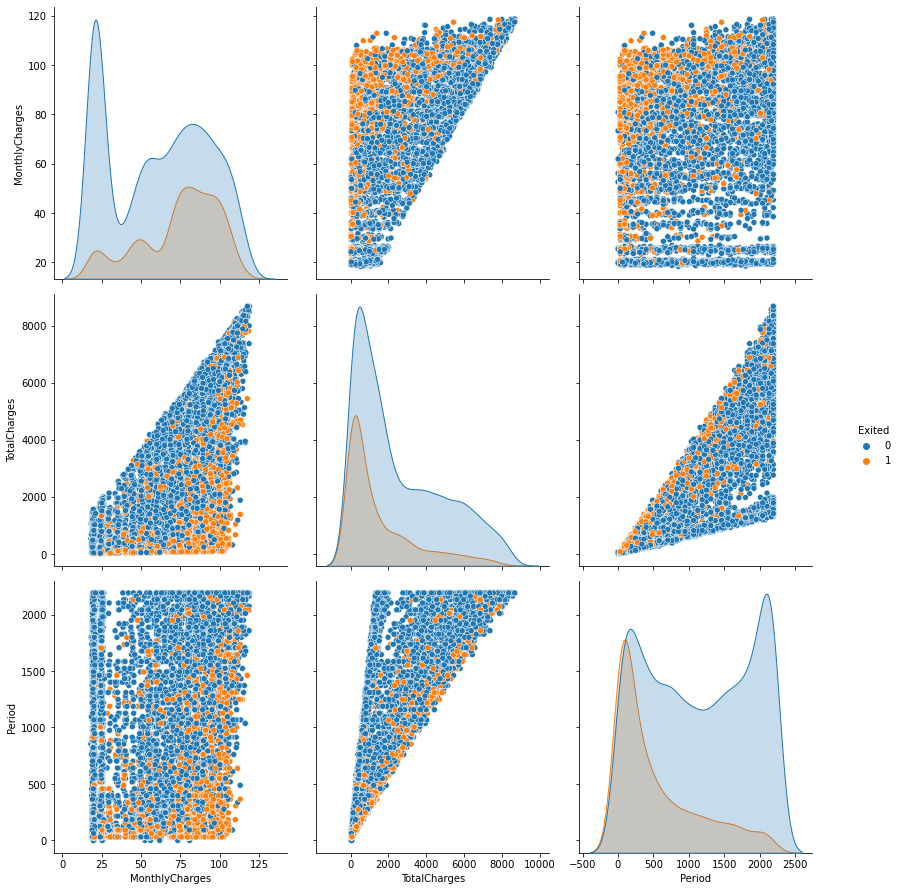

In [30]:
sns.pairplot(df_telecom, vars=col_num, hue='Exited').fig.set_size_inches(13,13);

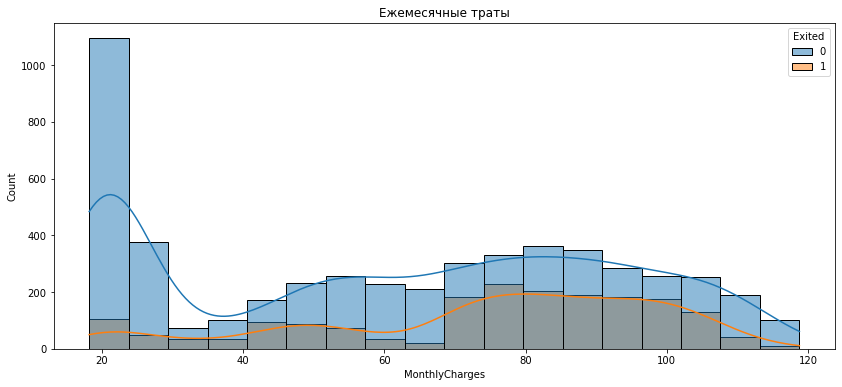

In [31]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.histplot(x=df_telecom.MonthlyCharges, hue=df_telecom.Exited, kde=True)
plt.title('Ежемесячные траты')
plt.show()

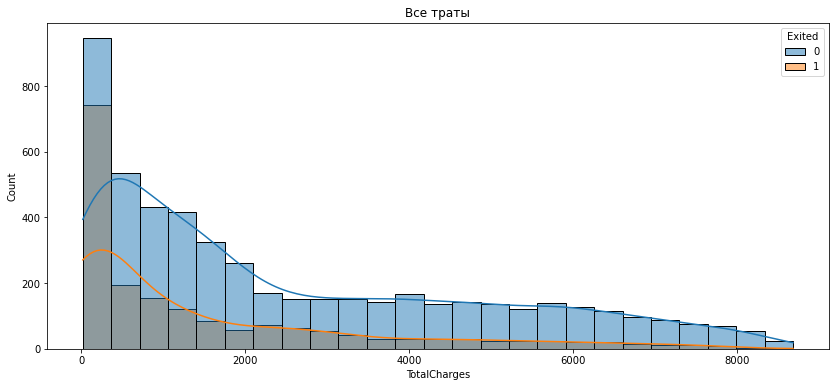

In [32]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.histplot(x=df_telecom.TotalCharges, hue=df_telecom.Exited, kde=True)
plt.title('Все траты')
plt.show()

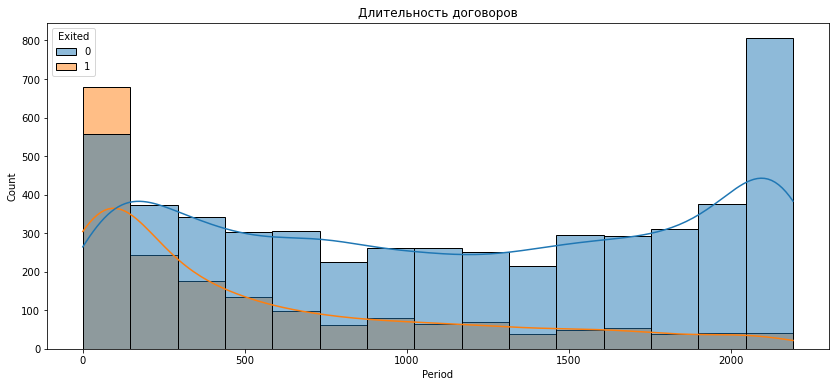

In [33]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.histplot(x=df_telecom.Period, hue=df_telecom.Exited, kde=True)
plt.title('Длительность договоров')
plt.show()

- Клиенты с невысоким ежемесячным платежом реже уходят.
- Данные с общими тратами распределены похоже.
- Большинство клиентов уходят в первые 3 месяца и, ожидаемо, чем дольше действует конракт, тем реже клиенты его расторгают.

In [34]:
df_telecom = df_telecom.drop(['gender', 'Partner'],axis=1)

### Анализ категориальных признаков

Сохраним и выведем список категориальных признаков

In [35]:
columns_cat = df_telecom.nunique()[df_telecom.nunique() < 5].keys().tolist()
columns_cat

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'Exited',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'SeniorCitizen',
 'Dependents',
 'MultipleLines']

Визуализируем распределение категориальных признаков

In [36]:
def features_cat(column):
    fig, ax = plt.subplots(figsize=(10, 4))
    plt.xticks(rotation=0)
    sns.countplot(x=column, data=df_telecom, palette='coolwarm')
    ax.set_title('Распределение по ' + column)
    plt.ylabel('Количество');

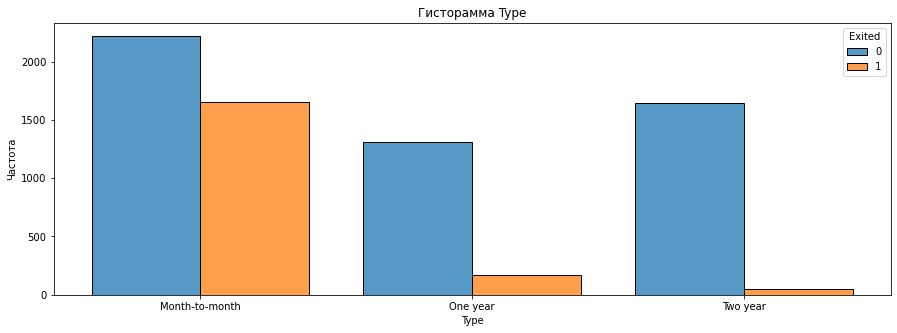

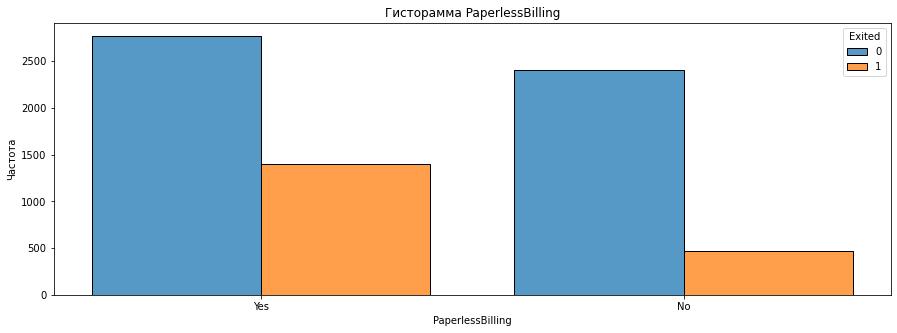

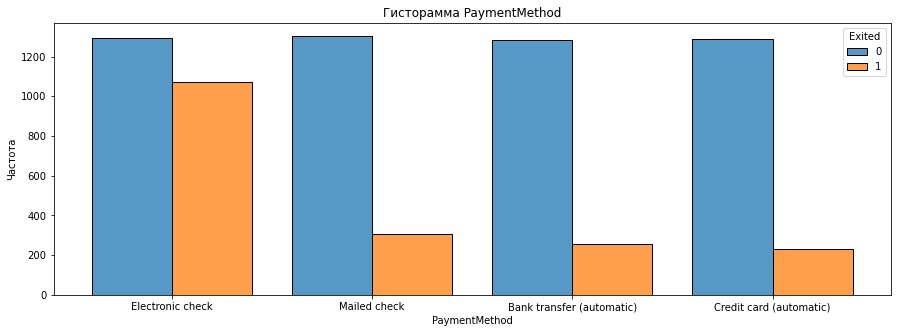

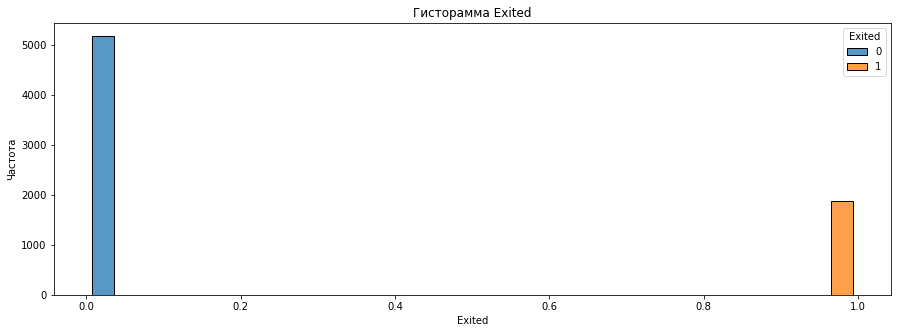

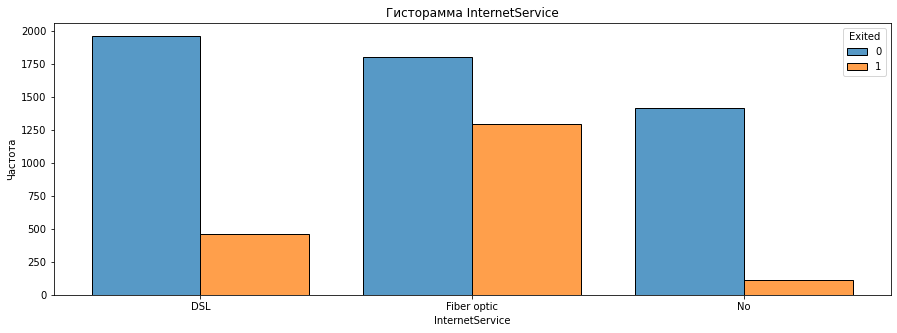

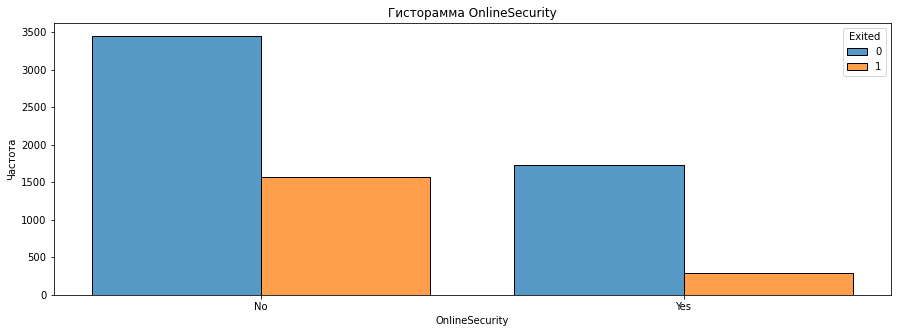

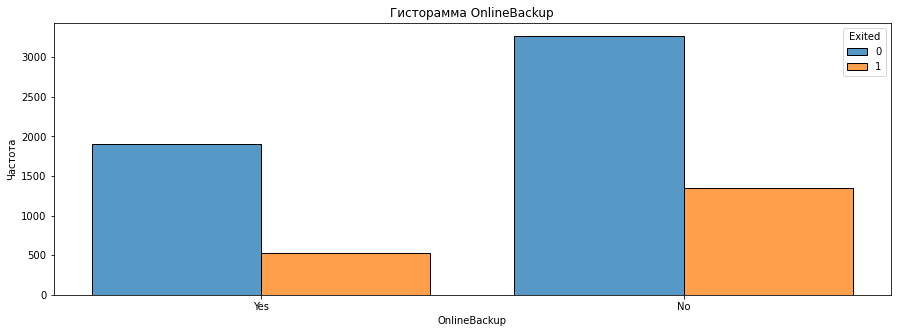

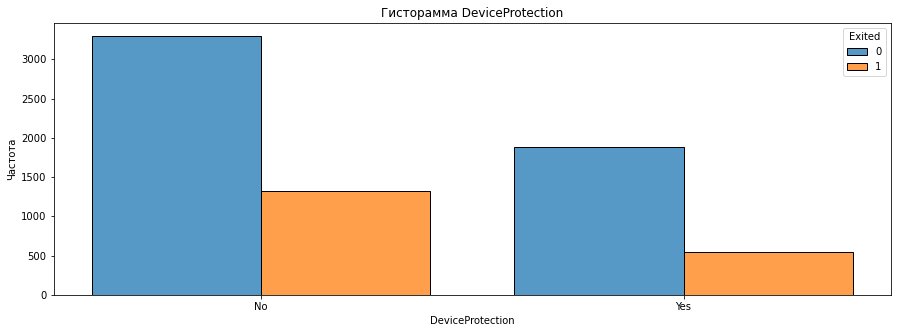

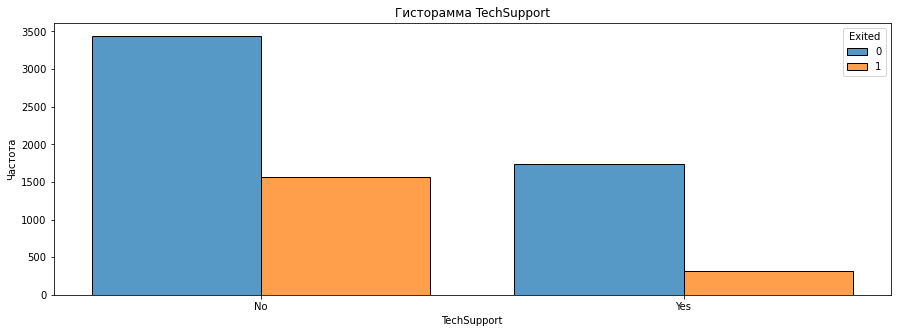

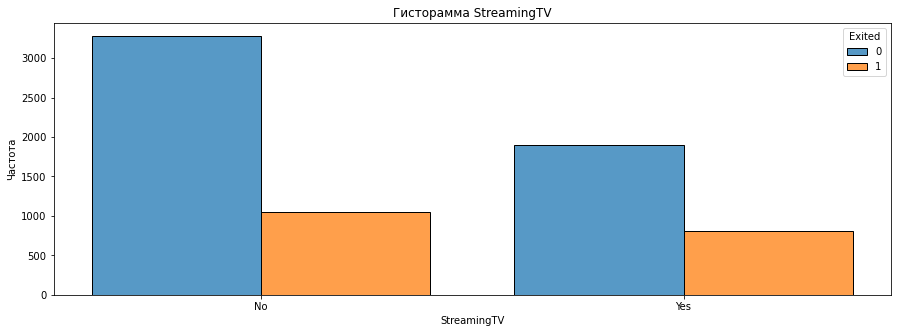

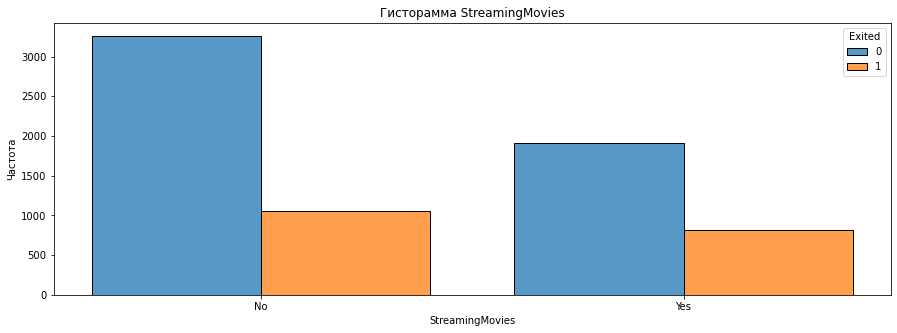

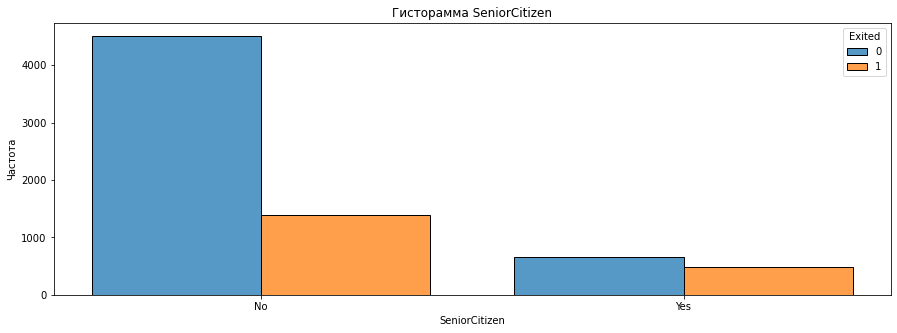

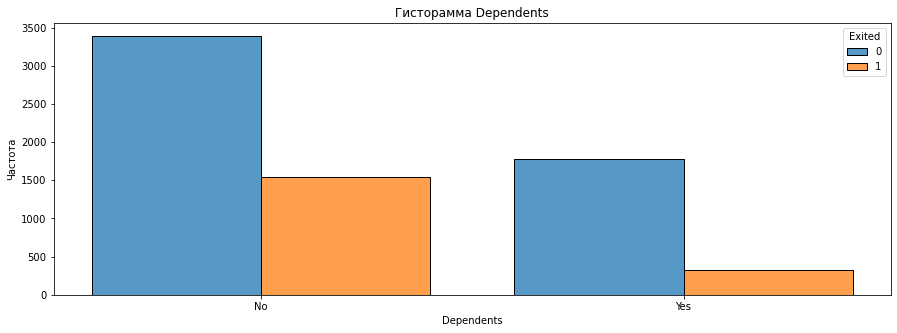

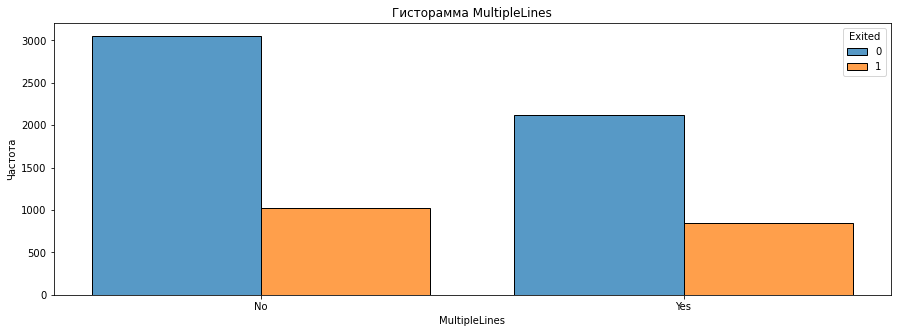

In [37]:
for i in columns_cat:
    plt.figure(figsize=(15,5))
    sns.histplot(data=df_telecom,x=i,hue=df_telecom['Exited'], multiple="dodge", shrink=.8)
    plt.ylabel('Частота')
    plt.xlabel(i)
    plt.title(f'Гисторамма {i}')
    plt.show()

Портрет ушедшего клиента:

    - Имеют невысокие ежемесячные траты на услуги, особенно на начальном периоде.
    - Основной отток происходит в первые 3 месяца обслуживания.
    - Общие траты на услуги гораздо ниже лояльных клиентов.
    - В основном, используют ежемесячный тип оплаты и редко оформляют подписки на 1 или 2 года.
    - Чаще используют безналичный рассчет оплаты.
    - Чаще используют оптоволоконное соединение.

Разделим на выборки

In [38]:
X = df_telecom.drop('Exited', 1)
y = df_telecom['Exited']

X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size = 0.25, stratify=y)

print(X_train.shape, X_test.shape)

(5282, 16) (1761, 16)


## Обучение модели

Предварительно, подготовим списки количественных и категориальных признаков

In [39]:
categorical = list(X_train.select_dtypes('object').columns)
numerical = list(X_train.select_dtypes('float64').columns)

### RandomForestClassifier

Подберем оптимальные параметры для RandomForestClassifier.\
Построим pipelline с предварительным кодированием категориальных признаков техникой OrdinalEncoder().\
Чтобы категории в трейне соответствовали категориям в тесте применим параметры (handle_unknown='use_encoded_value', unknown_value=-1)

In [40]:
parameters = {
            'rf__n_estimators' : [10,50,100],
            'rf__max_depth':[10,50,100,500]
}

cat_pipe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
preprocessor = ColumnTransformer([('cat', cat_pipe, categorical)], remainder='passthrough', sparse_threshold=0)

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(random_state=RANDOM_STATE))
])

cls_rf = GridSearchCV(pipe, parameters, scoring = 'roc_auc', cv=5)
cls_rf.fit(X_train, y_train)

roc_auc_rf = round(cls_rf.best_score_, 3)
roc_auc_rf

0.862

Проверка на кросс-валидации

In [42]:
scores = cross_val_score(cls_rf, X_train, y_train, cv=3)
mean_score_rf = round(sum(scores) / len(scores), 3)
mean_score_rf

0.86

### LogisticRegression

In [44]:
parameters = {
               'lreg__fit_intercept' : [True,False],
               'lreg__max_iter': [10,50,100,500],
               'lreg__class_weight': ['balanced'],
               'lreg__solver': ['newton-cg', 'liblinear', 'sag', 'saga'], 
               'lreg__multi_class':['auto', 'ovr'],
               'lreg__penalty' : ['l1'],
               'lreg__solver' :['saga','liblinear']
              }

cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

num_pipe = Pipeline([
    ('standard_scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_pipe, categorical),
    ('num', num_pipe, numerical)
])

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('lreg', LogisticRegression(random_state=RANDOM_STATE))
])

cls_lreg = GridSearchCV(
    estimator = pipe,
    param_grid = parameters,
    scoring = 'roc_auc',
    cv=5)

cls_lreg.fit(X_train, y_train)

roc_auc_lreg = round(cls_lreg.best_score_, 3)
roc_auc_lreg

0.847

Проверка на кросс-валидации

In [45]:
scores = cross_val_score(cls_lreg, X_train, y_train, cv=3)
mean_score_lreg = round(sum(scores) / len(scores), 3)
mean_score_lreg

0.847

### GradientBoostingClassifier

In [46]:
parameters = {
            'gbс__n_estimators' : range(1, 200, 50),
            'gbс__max_depth': range(1, 5)
}

cat_pipe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
preprocessor = ColumnTransformer([('cat', cat_pipe, categorical)], remainder='passthrough', sparse_threshold=0)

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('gbс', GradientBoostingClassifier(random_state=RANDOM_STATE))
])

cls_gbс = GridSearchCV(pipe, parameters, scoring = 'roc_auc', cv=5)
cls_gbс.fit(X_train, y_train)

roc_auc_gbс = round(cls_gbс.best_score_, 3)
roc_auc_gbс

0.9

Проверка на кросс-валидации

In [47]:
scores = cross_val_score(cls_gbс, X_train, y_train, cv=3)
mean_score_gbс = round(sum(scores) / len(scores), 3)
mean_score_gbс

0.894

### DecisionTreeClassifier

In [48]:
parameters = {
            'dtc__max_features': ['auto', 'sqrt', 'log2'],
            'dtc__min_samples_split': range(1, 15),
            'dtc__max_depth': range(1, 300, 50),
            'dtc__min_samples_leaf': range(1, 15)
}

cat_pipe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
preprocessor = ColumnTransformer([('cat', cat_pipe, categorical)], remainder='passthrough', sparse_threshold=0)

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('dtc', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

cls_dtc = GridSearchCV(pipe, parameters, scoring = 'roc_auc', cv=5)
cls_dtc.fit(X_train, y_train)

roc_auc_dtc = round(cls_dtc.best_score_, 3)
roc_auc_dtc

0.818

Проверка на кросс-валидации

In [49]:
scores = cross_val_score(cls_dtc, X_train, y_train, cv=3)
mean_score_dtc = round(sum(scores) / len(scores), 3)
mean_score_dtc

0.82

### Выбор модели

In [50]:
score = {}
score['RandomForestClassifier'] = [roc_auc_rf, mean_score_rf, accuracy_score(y_train,cls_rf.predict(X_train)), cls_rf.best_params_]
score['LogisticRegression'] = [roc_auc_lreg, mean_score_lreg, accuracy_score(y_train,cls_lreg.predict(X_train)), cls_lreg.best_params_]
score['GradientBoostingClassifier'] = [roc_auc_gbс, mean_score_gbс, accuracy_score(y_train,cls_gbс.predict(X_train)), cls_gbс.best_params_]
score['DecisionTreeClassifier'] = [roc_auc_dtc, mean_score_dtc, accuracy_score(y_train,cls_dtc.predict(X_train)), cls_dtc.best_params_]

df_score = pd.DataFrame.from_dict(data=score, columns=['roc_auc best_score', 'roc_auc cross_val', 'accuracy', 'best_params'], orient='index')
df_score

,roc_auc best_score,roc_auc cross_val,accuracy,best_params
RandomForestClassifier,0.862,0.860,0.886407,"{'rf__max_depth': 10, 'rf__n_estimators': 100}"
LogisticRegression,0.847,0.847,0.754449,"{'lreg__class_weight': 'balanced', 'lreg__fit_..."
GradientBoostingClassifier,0.900,0.894,0.897198,"{'gbс__max_depth': 4, 'gbс__n_estimators': 151}"
DecisionTreeClassifier,0.818,0.820,0.828095,"{'dtc__max_depth': 51, 'dtc__max_features': 'a..."


Лучший средний показатель roc_auc на cross_val у модели `GradientBoostingClassifier` (0.89). Проверим тестовые данные на ней.

### Тестирование модели

In [51]:
cat_pipe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
preprocessor = ColumnTransformer([('cat', cat_pipe, categorical)], remainder='passthrough', sparse_threshold=0)

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('gbс', GradientBoostingClassifier(max_depth=4, n_estimators=151, random_state=RANDOM_STATE))
])

model_gbc = pipe.fit(X_train, y_train)

pred_proba_test = model_gbc.predict_proba(X_test)[:, 1]
pred_test = model_gbc.predict(X_test)

print('Roc_auc score:', round(roc_auc_score(y_test, pred_proba_test), 3))
print('Accuracy score:', round(accuracy_score(y_test, pred_test), 3))
print('Presicion: ', round(precision_score(y_test, pred_test), 3))
print('Recall: ', round(recall_score(y_test, pred_test), 3))

Roc_auc score: 0.897
Accuracy score: 0.854
Presicion:  0.805
Recall:  0.593


Построим ROC-кривую для тестовой модели

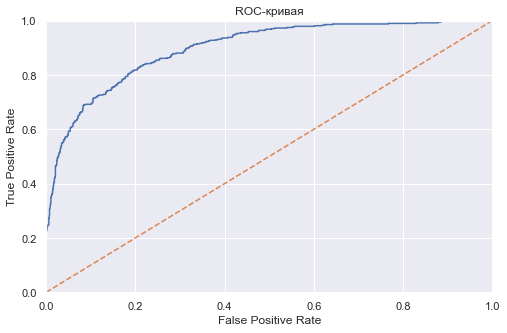

In [52]:
pred_proba_test = model_gbc.predict_proba(X_test)[:, 1]
pred_test = model_gbc.predict(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_proba_test)

sns.set()
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')
plt.show()

Кривая ошибок высокая. Высокие значения TPR свидетельствуют о неплохом качестве модели.

Выведем матрицу ошибок для тестовой модели

In [53]:
confusion_matrix(model_gbc.predict(X_test), y_test)

array([[1227,  190],
       [  67,  277]], dtype=int64)

Модель обладает высоким показателями истинно-положительных ответов (1227) и истинно-негативных (277), как следствие имеет высокую точность.\
Presicion (точность) модели:0.806\
Recall (полнота) модели:0.651

Построим график важности признаков итоговой модели

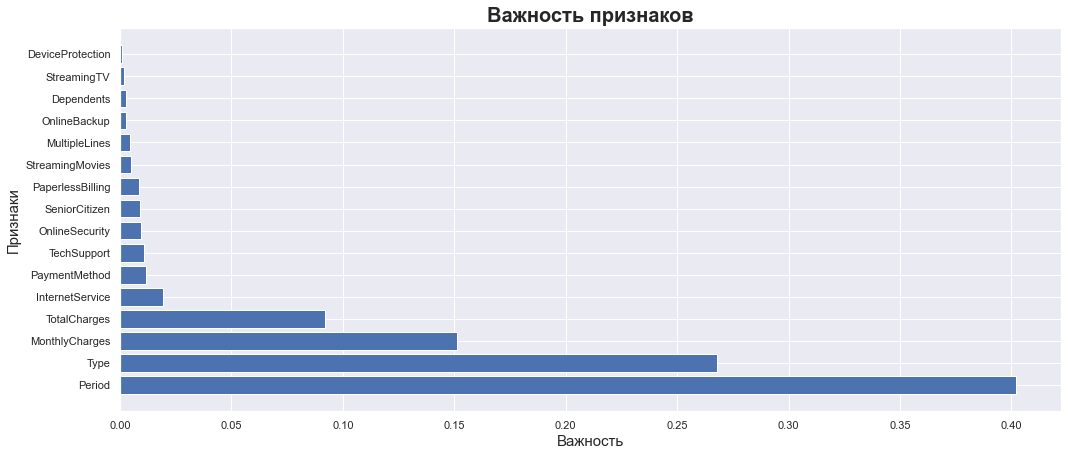

In [60]:
feature_importances = pd.DataFrame(model_gbc.steps[1][1].feature_importances_,
index=[categorical+numerical]).reset_index(drop=False)\
.rename(columns={"level_0": "Признаки", 0: "Важность"})\
.sort_values(by='Важность', ascending=False)

fig = plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.barh(feature_importances['Признаки'], feature_importances['Важность'])
plt.xlabel('Важность', fontsize=15)
plt.ylabel('Признаки', fontsize=15)
plt.title('Важность признаков', fontsize=20, weight = 'bold')
fig.tight_layout()
plt.show()

Согласно графику важности признаков можем выделить 5 наиболее значимых для данной модели: 

In [61]:
feature_importances.head()

,Признаки,Важность
15,Period,0.402297
0,Type,0.267886
13,MonthlyCharges,0.151432
14,TotalCharges,0.091928
3,InternetService,0.019314


# Вывод

**Провели исследование, согласно плану**

**1. Предварительный анализ.**
- Выгрузили данные из 4х датасетов с общим ключом `customerID`:
    - `contract.csv` — информация о договоре;
    - `personal.csv` — персональные данные клиента;
    - `internet.csv` — информация об интернет-услугах;
    - `phone.csv` — информация об услугах телефонии.
- Выявили, что данные содержат достаточную для анализа информацию и составлен **план работы:**
    1. Предварительный анализ
        - Выгрузка, чтение, получение общей информации.
        - Проверка валидности данных. Обработка пропусков и дубдикатов.
        - Объединение таблиц.
    2. Исследовательский анализ
        - Определить целевой признак.
        - Изучение корреляции признаков.
        - Анализ категориальных и количественных признаков.
        - Составить портрет клиента.
    3. Обучение модели
        - Предобработка данных для обучения. Масштабирование и кодирование признаков.
        - Выбор ключевой метрики.
        - Отбор необходимых признаков.
        - Подбор гиперпараметров и построение моделей.
        - Выбор лучшей модели.
    4. Тестирование лучшей модели
    5. Вывод

`Все шаги выполнены`

**2. Исследовательский анализ.**
- Добавили целевой признак `Exited`(ушел клиент или нет). Создали его спомощью столбца `EndDate` таблицы `contract`. Если на 1 февраля 2020 договор еще действет, считаем, что клиент не ушел.


- Создали новый признак с количеством дней действия договора 'period'.


- Изменили типы данных, где это было необходимо.


- Проведена работа с пропущенными значениями:
    - Для пользователей, которые только зарегестировались и их траты еще не попали в `TotalCharges`, заменили данные на значения столбца `MonthlyCharges`.
    
    
- Объединили таблицы в общий датасет функцией `merge` по ключу *customerID*


- Исходные таблицы имели разный размер, поэтому в новом датасете появились пропущенные значения. Посчитали допустимым замену их на 'No' - это незначительно повлияет на качество модели


- Перед нами задача бинарной классификации, поэтому столбцы с датами решено удалить из датасета, чтобы избежать утечки данных. Компенсируем их ранее созданым признаком 'period'.


- Изучили распределение значений целевого признака и сделали вывод - что имеем дело с серьёзным дисбалансом. В итоге:
    - Выбрали модели с встренными средствами балансировки.
    - Применили сэмплирование количественных признаков для Логистической регрессии.


- Провели анализ на мультиколлинеарность и влияние признаков на таргет. Исползовать phik, чтобы проследить коррелиальность числовых и категориальных признаков.


- Провели отдельный анали категориальных и количественных признаков в разрезе ушел/остался. Построили графики. В итоге избавились от столбцов `gender` и `Partner`, т.к. их значения на модель будет несущественным.

    В итоге сформирован портрет ушедшего клиента:
    - Имеют невысокие ежемесячные траты на услуги, особенно на начальном периоде.
    - Общие траты на услуги гораздо ниже лояльных клиентов.
    - Основной отток происходит в первые 3 месяца обслуживания.
    - В основном, используют ежемесячный тип оплаты и редко оформляют подписки на 1 или 2 года.
    - Чаще используют безналичный рассчет оплаты.
    - Чаще используют оптоволоконное соединение.
- Разделили датасет на тренеровочну и тестову выборки.

**3. Обучение и выбор лучшей модели**

- Выделили категориальные и количественные признаки.
- На тренировочных выборках провели обучение моделей и получили результат:

| Model                       | roc_auc best_score   | roc_auc cross_val    | accuracy  |
| :-------------------------  |:------------------   |:------------------   | :-------- |
| RandomForestClassifier      | 0.862                | 0.860                |0.886      |
| LogisticRegression          | 0.847                | 0.847                |0.754      |
| GradientBoostingClassifier  | 0.900                | 0.894                |0.897      |
| DecisionTreeClassifier      | 0.818                | 0.820                |0.828      |

- Выбрали лучшую модель по метрике roc_auc на кросс-валидации. Рекомендована модель GradientBoostingClassifier с гиперпараметрами (max_depth=4, n_estimators=151)

**4.Тестирование лучшей модели**

Проверили рекомендованную модель на тестовой выборке

    - в результате:

| Score   | GradientBoostingClassifier |
| :-------|:------|
| Roc_auc | 0.897 |
| Accuracy | 0.854 |
| Presicion | 0.805 |
| Recall | 0.593 |

- Кривая ошибок модели получилась высокая. Значения TPR свидетельствуют о неплохом качестве модели.


- Вывели матрицу ошибок.\
Модель имеет высокие показатели истинно-положительных ответов (1227) и истинно-негативных (277). Хорошую точность и среднюю полноту. Учитывая, наличие дисбаланса, метрику полноты (Recall) можно увеличить, однако, идеальный баланс между Presicion и Recall следует определить совместно с бизнесом, в зависимости от целей. Например, можно сосредоточиться на удержании vip-клинетов, которые приносят больше прибыли или тратить меньше денег на маркетинг, потенциально ушедших в будующем.


- Вывели график важности признаков итоговой модели. Выделили ТОП 5 самых важных для обучения:
| Признаки | Важность |
| :-------|:------|
| Period | 	0.402297 | 
| Type	| 0.267886 |
| MonthlyCharges |  0.151432 |
| TotalCharges	| 0.091928 |
| InternetService | 0.019314 |